学这个之前还是先看下这个视频，能减少很多弯路
https://www.bilibili.com/video/BV1KA411N7Px?p=2

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## 生成数据集

在下面的代码中，我们生成一个包含1000个样本的数据集，
每个样本包含从标准正态分布中采样的2个特征。
我们的合成数据集是一个矩阵$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$。

我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$


$\epsilon$可以视为模型预测和标签时的潜在观测误差。
在这里我们认为标准假设成立，即$\epsilon$服从均值为0的正态分布。
为了简化问题，我们将标准差设为0.01。




### 函数用法和相关笔记
#### torch.normal(means, std, out=None)

返回一个张量，包含从给定参数means,std的离散正态分布中抽取随机数。 均值means是一个张量，包含每个输出元素相关的正态分布的均值。 std是一个张量，包含每个输出元素相关的正态分布的标准差。 均值和标准差的形状不须匹配，但每个张量的元素个数须相同。

参数:

- means (Tensor) – 均值（平均值）
- std (Tensor) – 标准差 https://zh.wikihow.com/%E8%AE%A1%E7%AE%97%E6%A0%87%E5%87%86%E5%B7%AE
- out (Tensor) – 可选的输出张量

#### torch.matmul(input, other)

计算两个张量input和other的矩阵乘积，在PyTorch中可以通过torch.matmul函数实现

**注意**：matmul函数没有强制规定维度和大小，可以用利用广播机制进行不同维度的相乘操作。

In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    #means (Tensor) – 均值（平均值）
    #std (Tensor) – 标准差 https://zh.wikihow.com/%E8%AE%A1%E7%AE%97%E6%A0%87%E5%87%86%E5%B7%AE
    #out (Tensor) – 可选的输出张量
    X = torch.normal(0, 1, (num_examples, len(w)))
    print(X)
    #两个张量矩阵相乘，在PyTorch中可以通过torch.matmul函数实现
    y = torch.matmul(X, w) + b
    #print(y)
    y += torch.normal(0, 0.01, y.shape)
    #print(y)
    #torch.shape 和 torch.size()
    #-1表示总数所在的位置
    return X, y.reshape((-1, 1))
    
#创建张量
true_w = torch.tensor([2, -3.4])
print(true_w)
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

tensor([ 2.0000, -3.4000])
tensor([[-0.0108,  1.6086],
        [-1.0015,  1.1863],
        [ 0.3544,  1.4533],
        ...,
        [-1.1089,  0.0284],
        [-0.0183, -1.3571],
        [-1.4905,  0.5914]])


features中的每一行都包含一个二维数据样本， labels中的每一行都包含一维标签值（一个标量）

In [3]:
print('features:', features[0],'\nlabel:', labels[0])
print(features)

features: tensor([-0.0108,  1.6086]) 
label: tensor([-1.2969])
tensor([[-0.0108,  1.6086],
        [-1.0015,  1.1863],
        [ 0.3544,  1.4533],
        ...,
        [-1.1089,  0.0284],
        [-0.0183, -1.3571],
        [-1.4905,  0.5914]])


通过生成第二个特征features[:, 1]和labels的散点图， 可以直观观察到两者之间的线性关系。

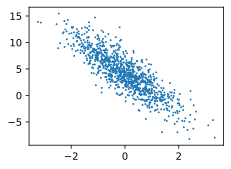

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);


## 读取数据集

我们定义一个data_iter函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。 每个小批量包含一组特征和标签。

### 函数用法和相关笔记
#### yueld用法

直接参考 https://blog.csdn.net/mieleizhi0522/article/details/82142856/

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    #print(num_examples)
    indices = list(range(num_examples))
    #print(indices)
    # 这些样本是随机读取的，没有特定的顺序,打乱位置
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        xs=indices[i: min(i + batch_size, num_examples)]
        #print(xs)
        batch_indices = torch.tensor(xs)
        #https://blog.csdn.net/mieleizhi0522/article/details/82142856/
        yield features[batch_indices], labels[batch_indices]

通常，我们利用GPU并行运算的优势，处理合理大小的“小批量”。 每个样本都可以并行地进行模型计算，且每个样本损失函数的梯度也可以被并行计算。 GPU可以在处理几百个样本时，所花费的时间不比处理一个样本时多太多。

我们直观感受一下小批量运算：读取第一个小批量数据样本并打印。 每个批量的特征维度显示批量大小和输入特征数。 同样的，批量的标签形状与batch_size相等。

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.1305e+00,  3.2709e+00],
        [ 1.3627e+00,  1.1092e+00],
        [-1.9896e-01,  2.1340e-03],
        [ 1.1513e+00, -9.6423e-01],
        [-4.3395e-02,  5.5221e-02],
        [-2.5389e-01,  9.2224e-01],
        [ 7.5067e-01,  6.4192e-01],
        [ 1.5814e+00, -8.4889e-01],
        [-5.1940e-02, -1.7965e+00],
        [-2.0882e-01,  9.8981e-01]]) 
 tensor([[-4.6588],
        [ 3.1488],
        [ 3.7812],
        [ 9.7822],
        [ 3.9241],
        [ 0.5573],
        [ 3.5126],
        [10.2525],
        [10.2048],
        [ 0.4128]])


## 初始化模型参数 

在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0。

### 函数用法和相关笔记
#### torch.zeros(size, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False)

返回一个形状为为size，类型为torch.dtype，里面的每一个值都是0的tensor

参数:

- size：定义tensor的shape ，这里可以是一个list 也可以是一个tuple
- dtype：（可选）我不设置值 默认值就是torch.set_default_tensor_type制定的值，如果需要设置那就是torch.dtype的那几个。作用是指定返回tensor的数据类型
- layout：（可选）值为 torch.layout。 torch.layout表示torch.Tensor内存布局的对象。有torch.strided(dense Tensors 默认)并为torch.sparse_coo(sparse COO Tensors)提供实验支持。torch.strided代表密集张量，是最常用的内存布局。每个strided张量都会关联 一个torch.Storage，它保存着它的数据。这些张力提供了多维度， 存储的strided视图。Strides是一个整数型列表：k-th stride表示在张量的第k维从一个元素跳转到下一个元素所需的内存。关于这里的理解请看demo2
- device：（可选）就是创建的tensor存放的device,这里就不做赘述了，大致概念了解看这里\
- requires_grad：（可选）是bool 类型的值，默认值是False .因为 pytorch 后期的版本将Varibale 和Tensor进行合并了，这里的如果设置为Flase 表示再反响传播的时候不会对这个节点机型求导，如果你对tensorflow熟悉

In [14]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 定义模型
我们只需计算输入特征$\mathbf{X}$和模型权重$\mathbf{w}$的矩阵-向量乘法后加上偏置$b$。
注意，上面的$\mathbf{Xw}$是一个向量，而$b$是一个标量。
回想一下广播机制：
当我们用一个向量加一个标量时，标量会被加到向量的每个分量上。

In [8]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

## 定义损失函数
因为需要计算损失函数的梯度，所以我们应该先定义损失函数。在实现中，我们需要将真实值y的形状转换为和预测值y_hat的形状相同

In [9]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    #print(y_hat.shape)
    #print(y_hat)
    #真实值y的形状转换为和预测值y_hat的形状相同
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 定义优化算法
下面的函数实现小批量随机梯度下降更新。 该函数接受模型参数集合、学习速率和批量大小作为输入。每 一步更新的大小由学习速率lr决定。 因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（batch_size） 来规范化步长，这样步长大小就不会取决于我们对批量大小的选择

In [10]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    #with 语句适用于对资源进行访问的场合，确保不管使用过程中是否发生异常都会执行必要的“清理”操作，释放资源，比如文件使用后自动关闭／线程中锁的自动获取和释放等。
    # no_grad用来关闭梯度计算
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            #需要清理梯度值不然会累加
            param.grad.zero_()

## 训练
现在我们已经准备好了模型训练所有需要的要素，可以实现主要的训练过程部分了。
理解这段代码至关重要，因为从事深度学习后，
相同的训练过程几乎一遍又一遍地出现。
在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。
计算完损失后，我们开始反向传播，存储每个参数的梯度。
最后，我们调用优化算法`sgd`来更新模型参数。

概括一下，我们将执行以下循环：

* 初始化参数
* 重复以下训练，直到完成
  * 计算梯度$\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
  * 更新参数$(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

在每个*迭代周期*（epoch）中，我们使用`data_iter`函数遍历整个数据集，
并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。
这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设为3和0.03。
设置超参数很棘手，需要通过反复试验进行调整。


### 函数用法和相关笔记
#### 关于tensor中的is_leaf属性

在pytorch的tensor类中,有个is_leaf的属性,姑且把它作为叶子节点. is_leaf 为False的时候,则不是叶子节点, is_leaf为True的时候为叶子节点(或者叶张量)

**所以问题来了: leaf的作用是什么?为什么要加 leaf?**

我们都知道tensor中的requires_grad()属性，当requires_grad()为True时我们将会记录tensor的运算过程并为自动求导做准备，但是并不是每个requires_grad()设为True的值都会在backward的时候得到相应的grad。它还必须为leaf。这就说明。**leaf成为了在 requires_grad()下判断是否需要保留 grad的前提条件**

is_leaf()
- 按照惯例,所有requires_grad为False的张量(Tensor) 都为叶张量( leaf Tensor)
- requires_grad为True的张量(Tensor),如果他们是由用户创建的,则它们是叶张量(leaf Tensor).这意味着它们不是运算的结果,因此gra_fn为None
- 只有是叶张量的tensor在反向传播时才会将本身的grad传入的backward的运算中. 如果想得到当前tensor在反向传播时的grad, 可以用retain_grad()这个属性


```python
>>> a = torch.rand(10, requires_grad=True)
>>> a.is_leaf
True
>>> b = torch.rand(10, requires_grad=True).cuda()
>>> b.is_leaf
False
# b was created by the operation that cast a cpu Tensor into a cuda Tensor
>>> c = torch.rand(10, requires_grad=True) + 2
>>> c.is_leaf
False
# c was created by the addition operation
>>> d = torch.rand(10).cuda()
>>> d.is_leaf
True
# d does not require gradients and so has no operation creating it (that is tracked by the autograd engine)
>>> e = torch.rand(10).cuda().requires_grad_()
>>> e.is_leaf
True
# e requires gradients and has no operations creating it
>>> f = torch.rand(10, requires_grad=True, device="cuda")
>>> f.is_leaf
True
```

### autograd 流程图

视频地址：https://www.youtube.com/watch?v=MswxJw-8PvE

[draw.io](https://github.com/Ascotbe/Image/blob/master/Jupyter/LinearRegression/PyTorch%20Autograd)

例

```python
a = torch.tensor(2.0)
b = torch.tensor(3.0)
c = a*b 
```

项的计算图如下:
每个方框代表一个tensor，其中列出一些属性（还有其他很多属性）：

- .data 存了tensor的data
- .grad 当计算gradient的时候将会存入此函数对应情况下的gradient
- .grad_fn 指向用于backward的函数的节点
- .is_leaf 判断是否是叶节点 leaf 叶子(张量)
- .requires_grad 如果是设为`True`,那么在做backward时候将作为图的一部分参与backwards运算,如果为`False`则不参加backwards运算

![](https://raw.githubusercontent.com/Ascotbe/Image/master/Jupyter/LinearRegression/1.png)

在图中可见，`c= a*b`的运算也算作计算图的一部分，用Mul表示。由于a和b是require_grad所以自动的被算为is_leaf为`True`，此时由于requires_grad都为`False`，因此没有backwards的graph。


---

例

```python
a = torch.tensor(2.0,requires_grad = True)
b = torch.tensor(3.0)
c = a*b 
c.backward()
```

重新进行计算,设tensor a的requires_grad为`True`，输出结果c因为输入自变量的属性为`True`而自动改变成requires_grad为`True`。这说明只要自变量中有一个requires_grad为`True`，进一步通过运算生成的变量也为`True`。此时的c 为非叶节点，grad_fn指向做backwards时与当前变量相关的backwards的函数(函数为pytorch自动生成的)。

![](https://raw.githubusercontent.com/Ascotbe/Image/master/Jupyter/LinearRegression/2.png)

这是算数式的前馈流程图，使我们可以通过函数代码观察到的。在此流程图的背后，其实pytorch还自动生成了对应的backwards的流程图：

![](https://raw.githubusercontent.com/Ascotbe/Image/master/Jupyter/LinearRegression/3.png)

1. 当我们调用tensor的乘法函数时，同时调用了隐性变量 ctx (context)变量的save_for_backward()，这样就把此函数做backward时所需要的从forward函数中获取的相关的一些值存到了ctx中。ctx起到了缓存相关参数的作用，变成连接forward与backward之间的缓存站。ctx中的值将会在c做backwards时传递给对应的Mulbackward操作。

2. 与此同时由于c是通过`c=a*b`运算得来的，c的grad_fn中存了做backwards时候对应的函数。且把这个对应的backward叫做 “MulBackward”
3. 当进行c的backwards的时候，其实也就相当于执行了`c = a*b`这个函数分别对a与b做的偏导。那么理应对应两组backwards的函数，这两组backwards的函数打包存在MulBackward的next_functions中。nex_function为一个**tuple list**，AccumulateGrad将会把相应得到的结果送到a.grad中。
4. 于是在进行c.backward()后，c进行关于a以及关于b的求导，由于b设requires_grad为`False`，因此b项不参与backwards运算(自然的，next_function中list的第二个tuple即为None)，c关于a的梯度为3，因此3将传递给AccumulaGrad进一步传给a.grad。因此a.grad的结果为3

> 从这个backward graph中，可以看出，其实pytorch在定义这些变量的运算函数时，其实也定义了函数对应的backwards的函数。如果想使用自定义的函数，那么自己也必须要定义backwards函数。

例 3

```python
a = torch.tensor(2.0,requires_grad = True)
b = torch.tensor(3.0,requires_grad = True)
c = a*b 
d = torch.tensor(4.0,requires_grad = True)
e = c*d
e.backward()
```

![](https://raw.githubusercontent.com/Ascotbe/Image/master/Jupyter/LinearRegression/4.png)

1. e的grad_fn指向节点MulBackward，c的grad_fn指向另一个节点MulBackward
2. c为中间值is_leaf为`False`，因此并不包含grad值，在backward计算中，并不需要再重新获取c.grad的值，backward的运算直接走相应的backward node即可
3. MulBackward从ctx.saved_tensor中调用有用信息，e= c+d中e关于c的梯度通过MulBackward获取得4。根据链式规则，4再和上一阶段的c关于a和c关于b的两个梯度值3和2相乘，最终得到了相应的值12和8
4. a.grad中存入12，b.grad中存入8

### gradient最通俗的解释
#### 前言

在深度学习中，经常需要对函数求梯度（gradient）。**PyTorch提供的autograd包能够根据输入和前向传播过程自动构建计算图，并执行反向传播**。本文主要通过例子来介绍一下pytorch中torch.Tensor.backward()的简单用法。

#### 标量变量的反向传播

PyTorch中，torch.Tensor是存储和变换数据的主要工具。如果你之前用过NumPy，你会发现Tensor和NumPy的多维数组非常类似。然而，Tensor提供**GPU计算**和**自动求梯度**等更多功能，这些使Tensor更加适合深度学习。

如果将PyTorch中的**tensor属性requires_grad**设置为True，它将开始**追踪(track)**在其上的所有操作（这样就可以利用链式法则进行梯度传播了）。完成计算后，可以调用backward()来完成所有梯度计算。**此tensor的梯度将累积到grad属性中**。
下面我们来看一个例子。

```python
import torch

x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
y = x ** 2 + 2
z = torch.sum(y)
z.backward()
print(x.grad)
tensor([2., 4., 6.])
```

设$x=\left[x_{1}, x_{2}, x_{3}\right]$，则

$\begin{array}{l}z=x_{1}^{2}+x_{2}^{2}+x_{3}^{2}+6
\end{array}$


由求偏导的数学知识，可知:

$\begin{aligned}
\frac{\partial z}{\partial x_{1}} & =2 x_{1} \\
\frac{\partial z}{\partial x_{2}} & =2 x_{2} \\
\frac{\partial z}{\partial x_{3}} & =2 x_{3}
\end{aligned}$


然后把$x_{1}=1.0, x_{2}=2.0, x_{3}=3.0$代入得到

$\left(\frac{\partial z}{\partial x_{1}}, \frac{\partial z}{\partial x_{2}}, \frac{\partial z}{\partial x_{3}}\right)=\left(2 x_{1}, 2 x_{2}, 2 x_{3}\right)=(2.0,4.0,6.0)$

可见结果与PyTorch的输出一致。

#### 非标量变量的反向传播

同样，先看下面的例子。已知，

$\begin{array}{c}
y_{1}=x_{1} x_{2} x_{3} \\
y_{2}=x_{1}+x_{2}+x_{3} \\
y_{3}=x_{1}+x_{2} x_{3} \\
A=f\left(y_{1}, y_{2}, y_{3}\right)
\end{array}$


其中函数$f(y_{1}, y_{2}, y_{3})$的具体定义未知，现在求:

$\begin{aligned}
\frac{\partial A}{\partial x_{1}} & =? \\
\frac{\partial A}{\partial x_{2}} & =? \\
\frac{\partial A}{\partial x_{3}} & =?
\end{aligned}$

根据多元复合函数的求导法则，有：

$\begin{array}{l}
\frac{\partial A}{\partial x_{1}}=\frac{\partial A}{\partial y_{1}} \frac{\partial y_{1}}{\partial x_{1}}+\frac{\partial A}{\partial y_{2}} \frac{\partial y_{2}}{\partial x_{1}}+\frac{\partial A}{\partial y_{3}} \frac{\partial y_{3}}{\partial x_{1}} \\
\frac{\partial A}{\partial x_{2}}=\frac{\partial A}{\partial y_{1}} \frac{\partial y_{1}}{\partial x_{2}}+\frac{\partial A}{\partial y_{2}} \frac{\partial y_{2}}{\partial x_{2}}+\frac{\partial A}{\partial y_{3}} \frac{\partial y_{3}}{\partial x_{2}} \\
\frac{\partial A}{\partial x_{3}}=\frac{\partial A}{\partial y_{1}} \frac{\partial y_{1}}{\partial x_{3}}+\frac{\partial A}{\partial y_{2}} \frac{\partial y_{2}}{\partial x_{3}}+\frac{\partial A}{\partial y_{3}} \frac{\partial y_{3}}{\partial x_{3}}
\end{array}$

上面3个等式可以写成**矩阵相乘的形式**，如下:

$\left[\frac{\partial A}{\partial x_{1}}, \frac{\partial A}{\partial x_{2}}, \frac{\partial A}{\partial x_{3}}\right]=\left[\frac{\partial A}{\partial y_{1}}, \frac{\partial A}{\partial y_{2}}, \frac{\partial A}{\partial y_{3}}\right]\left[\begin{array}{ccc}
\frac{\partial y_{1}}{\partial x_{1}} & \frac{\partial y_{1}}{\partial x_{2}} & \frac{\partial y_{1}}{\partial x_{3}} \\
\frac{\partial y_{2}}{\partial x_{1}} & \frac{\partial y_{2}}{\partial x_{2}} & \frac{\partial y_{2}}{\partial x_{3}} \\
\frac{\partial y_{3}}{\partial x_{1}} & \frac{\partial y_{3}}{\partial x_{2}} & \frac{\partial y_{3}}{\partial x_{3}}
\end{array}\right]$

其中

$\begin{array}{l}
{\left[\begin{array}{lll}
\frac{\partial y_{1}}{\partial x_{1}} & \frac{\partial y_{1}}{\partial x_{2}} & \frac{\partial y_{1}}{\partial x_{3}} \\
\frac{\partial y_{2}}{\partial x_{1}} & \frac{\partial y_{2}}{\partial x_{2}} & \frac{\partial y_{2}}{\partial x_{3}} \\
\frac{\partial y_{3}}{\partial x_{1}} & \frac{\partial y_{3}}{\partial x_{2}} & \frac{\partial y_{3}}{\partial x_{3}}
\end{array}\right]} \\
\end{array}$

叫作**雅可比(Jacobian)式**。雅可比式可以根据已知条件求出。

现在只要知道$\left[\frac{\partial y_1}{\partial A}, \frac{\partial  y_2}{\partial A}, \frac{\partial y_3}{\partial A}\right]$的值，哪怕不知道$f\left(y_{1}, y_{2}, y_{3}\right)$的具体形式也能求出来$\left[\frac{\partial x_1}{\partial A}, \frac{\partial  x_2}{\partial A}, \frac{\partial x_3}{\partial A}\right]$

那现在的问题是怎么样才能求出

$\left[\frac{\partial A}{\partial y_{1}}, \frac{\partial A}{\partial y_{2}}, \frac{\partial A}{\partial y_{3}}\right]$

**答案是由PyTorch的backward函数的gradient参数提供。这就是gradient参数的作用。**

比如，我们传入gradient参数为`torch.tensor([0.1，0.2，0.3], dtype=torch.float)`，并且假定$x_{1}=1, x_{2}=2, x_{3}=3$，按照上面的推导方法:

$\left[\frac{\partial A}{\partial x_{1}}, \frac{\partial A}{\partial x_{2}}, \frac{\partial A}{\partial x_{3}}\right]=\left[\frac{\partial A}{\partial y_{1}}, \frac{\partial A}{\partial y_{2}}, \frac{\partial A}{\partial y_{3}}\right]\left[\begin{array}{ccc}
x_{2} x_{3} & x_{1} x_{3} & x_{1} x_{2} \\
1 & 1 & 1 \\
1 & x_{3} & x_{2}
\end{array}\right]=[0.1,0.2,0.3]\left[\begin{array}{lll}
6 & 3 & 2 \\
1 & 1 & 1 \\
1 & 3 & 2
\end{array}\right]=[1.1,1.4,1.0]$

我们可以用代码验证一下：

```python
import torch

x1 = torch.tensor(1, requires_grad=True, dtype=torch.float)
x2 = torch.tensor(2, requires_grad=True, dtype=torch.float)
x3 = torch.tensor(3, requires_grad=True, dtype=torch.float)

x = torch.tensor([x1, x2, x3])
y = torch.randn(3)

y[0] = x1 * x2 * x3
y[1] = x1 + x2 + x3
y[2] = x1 + x2 * x3

y.backward(torch.tensor([0.1, 0.2, 0.3], dtype=torch.float))

print(x1.grad, x2.grad, x3.grad)
tensor(1.1000) tensor(1.4000) tensor(1.)
```

由此可见，推导和代码运行结果一致。

当$y$不是标量时，**向量$y$**关于向量$x$的导数的**最自然解释是⼀个矩阵**。**对于高阶和高维的$y$和$x$，求导的结果可以是⼀个高阶张量**。

然而，虽然这些更奇特的对象确实出现在高级机器学习中（包括深度学习中），**但当我们调用向量的反向计算时，我们通常会试图计算一批训练样本中每个组成部分的(这里我的理解是关于非标量$y$的各个维度的)损失函数的导数。这里，我们的目的不是计算微分矩阵，而是单独计算批量中每个样本的(这里我的理解是关于非标量$y$的各个维度的)偏导数之和。对非标量，调⽤backward，需要传⼊⼀个gradient参数，该参数指定微分函数关于self的梯度**。

```python
import torch
x = torch.arange(4.0)
y = x * x
# 等价于y.sum().backward()
y.backward(torch.ones(len(x)))
x.grad
tensor([0., 2., 4., 6.])
```

In [11]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.039128
epoch 2, loss 0.000144
epoch 3, loss 0.000050


因为我们使用的是自己合成的数据集，所以我们知道真正的参数是什么。 因此，我们可以通过比较真实参数和通过训练学到的参数来评估训练的成功程度。 事实上，真实参数和通过训练学到的参数确实非常接近。

In [12]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0004, -0.0006], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0004], grad_fn=<RsubBackward1>)
